# Functions

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from numpy import linalg as LA
from sklearn.mixture import GaussianMixture
import seaborn as sns

In [2]:
D = 5
THETA = np.ones(D)/np.sqrt(D)

In [3]:
def create_dataset_symmetric_mixture (theta = THETA, d=D, n_1_unl=1000, n_2_unl=1000, n_1_labeled=10, n_2_labeled=10, sigma_1=1, sigma_2=1, seed=0):
  
  np.random.seed(seed)

  n_1 = n_1_unl + n_1_labeled
  n_2 = n_2_unl + n_2_labeled

  mu_1 =  theta
  mu_2 = - theta

  x_1 = sigma_1*np.random.randn(int(n_1), d) + mu_1[None, :]
  if n_1_labeled != 0:
    x_1_labeled = x_1[:n_1_labeled,:]
  else:
    x_1_labeled = None

  x_2 = sigma_2*np.random.randn(int(n_2), d) + mu_2[None, :]
  if n_2_labeled!= 0:
    x_2_labeled = x_2[:n_2_labeled,:]
  else:
    x_2_labeled = None

  if n_1_unl != 0:
    x_unlabeled = np.append(x_1[n_1_labeled:n_1,:], x_2[n_2_labeled:n_2,:], axis=0)
  else:
    x_unlabeled = None

  return x_1_labeled, x_2_labeled, x_unlabeled

In [4]:
def plot(x_1_labeled, x_2_labeled, x_unlabeled, W_OPT= np.ones(2)/np.sqrt(2), GAMMA=None , LIM=10):
  _, ax = plt.subplots()
  ax.set_aspect('equal', adjustable='box')
  ax.set_xlim(-LIM, LIM)
  ax.set_ylim(-LIM, LIM)


  # opt & margin
  _x = np.linspace(-LIM, LIM, 100)
  _y = - W_OPT[0] * _x / W_OPT[1]
  ax.plot(_x, _y, c='black')

  if GAMMA is not None:
      ax.plot(_x, _y + GAMMA, c='grey')
      ax.plot(_x, _y - GAMMA, c='grey')


  ax.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], marker='.', c='lightblue', s=5)
  ax.scatter(x_1_labeled[:, 0],x_1_labeled[:, 1], marker='+', c='blue', s=20)
  ax.scatter(x_2_labeled[:, 0], x_2_labeled[:, 1], marker='_', c='red', s=20)

  plt.show()

In [5]:
x_1_labeled, x_2_labeled, x_unlabeled = create_dataset_symmetric_mixture(theta=THETA, n_1_unl=1000, n_2_unl=1000, n_1_labeled=100, n_2_labeled=100)

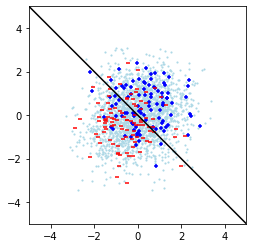

In [6]:
plot(x_1_labeled, x_2_labeled, x_unlabeled, LIM=5 )

In [7]:
def est_sup(x_1_labeled, x_2_labeled):
  return np.mean(np.append(x_1_labeled, -x_2_labeled, axis = 0), axis=0)

In [8]:
def unsup_est(x_unlabeled):
  unl_cov = np.transpose(x_unlabeled) @ x_unlabeled / x_unlabeled.shape[0]
  eigvals, eigvecs = LA.eigh(unl_cov)
  s = np.sqrt(eigvals[-1] - 1)
  v = eigvecs[:, -1]
  est_unl = s*v
  return est_unl


In [9]:
def expectation_maximization_kmeans_init(x_unlabeled=x_unlabeled):
  gm = GaussianMixture(n_components=2, random_state=0).fit(x_unlabeled)
  return gm.means_

In [10]:
def expectation_maximization_supervised_init(x_unlabeled=x_unlabeled,x_1_labeled= x_1_labeled, x_2_labeled= x_2_labeled ):
  mean_1 = np.mean(x_1_labeled, axis=0)
  mean_2 = np.mean(x_2_labeled, axis=0)
  means_init = np.append(mean_1[None, :], mean_2[None, :] ,axis=0)
  gm = GaussianMixture(n_components=2, random_state=0, means_init = means_init ).fit(x_unlabeled)
  return gm.means_

# Estimator in the upper-bound

In [16]:
exp_sup_error = []
exp_uns_error = []
exp_ssl_error = []
s_values = np.linspace(0,2,100)
for s in s_values:
  err_s = []
  err_u = []
  for seed in range(10):
    x_1_labeled, x_2_labeled, x_unlabeled = create_dataset_symmetric_mixture(theta=s*THETA, n_1_unl=1000, n_2_unl=1000, n_1_labeled=100, n_2_labeled=100, seed= seed)
    est_s = est_sup(x_1_labeled, x_2_labeled)
    est_u = unsup_est(x_unlabeled)
    err_s.append(np.linalg.norm(s*THETA - est_s)**2)
    err_u.append(min([np.linalg.norm(s*THETA - est_u), np.linalg.norm(-s*THETA - est_u)])**2)

  exp_sup_error.append(np.mean(err_s))
  exp_uns_error.append(np.mean(err_u))

lamd_est_s = [exp_uns_error[i]/(exp_sup_error[i]+ exp_uns_error[i]) for i in range(len(exp_uns_error))]

exp_sup_error = []
exp_uns_error = []
exp_ssl_error = []

for ind, s in enumerate(s_values):
  err_s = []
  err_u = []
  err_ssl = []
  for seed in range(10, 20):
    x_1_labeled, x_2_labeled, x_unlabeled = create_dataset_symmetric_mixture(theta=s*THETA, n_1_unl=1000, n_2_unl=1000, n_1_labeled=100, n_2_labeled=100, seed= seed)
    est_s = est_sup(x_1_labeled, x_2_labeled)
    est_u = unsup_est(x_unlabeled)
    err_s.append(np.linalg.norm(s*THETA - est_s)**2)
    err_u.append(min([np.linalg.norm(s*THETA - est_u), np.linalg.norm(s*THETA + est_u)])**2)
    err_ssl.append(min([np.linalg.norm(s*THETA - (lamd_est_s[ind]*est_s + (1-lamd_est_s[ind])*est_u )), np.linalg.norm(s*THETA - (lamd_est_s[ind]*est_s - (1-lamd_est_s[ind])*est_u ))])**2)

  exp_sup_error.append(np.mean(err_s))
  exp_uns_error.append(np.mean(err_u))
  exp_ssl_error.append(np.mean(err_ssl))

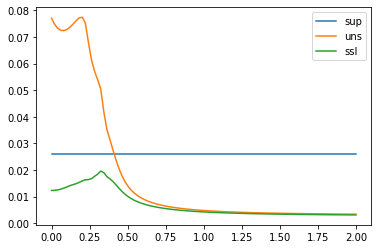

In [17]:
plt.plot(s_values,exp_sup_error, label="sup" )
plt.plot(s_values,exp_uns_error, label="uns" )
plt.plot(s_values,exp_ssl_error, label="ssl" )

plt.legend()

In [18]:
def plot_vary_s_fixed_dataset_size(n_l, n_u, uns_estimator_type= 'emp_cov', ssl_estimator_type='combined', num_weight_est_seed = 100, num_seed= 100):
    exp_sup_error = []
    exp_uns_error = []
    exp_ssl_error = []
    s_values = np.linspace(0,2,100)
    for s in s_values:
    err_s = []
    err_u = []
    for seed in range(num_weight_est_seed):
      x_1_labeled, x_2_labeled, x_unlabeled = create_dataset_symmetric_mixture(theta=s*THETA, n_1_unl=1000, n_2_unl=1000, n_1_labeled=100, n_2_labeled=100, seed= seed)
      est_s = est_sup(x_1_labeled, x_2_labeled)
      if uns_estimator_type=='emp_cov':
        est_u = unsup_est(x_unlabeled)
      elif uns_estimator_type=='EM':
        em_means = expectation_maximization_kmeans_init(x_unlabeled=x_unlabeled)
        est_u = em_means[0,:] - em_means[1,:]

      err_s.append(np.linalg.norm(s*THETA - est_s)**2)
      err_u.append(min([np.linalg.norm(s*THETA - est_u), np.linalg.norm(-s*THETA - est_u)])**2)

    exp_sup_error.append(np.mean(err_s))
    exp_uns_error.append(np.mean(err_u))

    lamd_est_s = [exp_uns_error[i]/(exp_sup_error[i]+ exp_uns_error[i]) for i in range(len(exp_uns_error))]

    exp_sup_error = []
    exp_uns_error = []
    exp_ssl_error = []

    std_sup_error = []
    std_uns_error = []
    std_ssl_error = []

    for ind, s in enumerate(s_values):
    err_s = []
    err_u = []
    err_ssl = []
    for seed in range(num_weight_est_seed, num_weight_est_seed+num_seed):
      x_1_labeled, x_2_labeled, x_unlabeled = create_dataset_symmetric_mixture(theta=s*THETA, n_1_unl=int(n_u/2), n_2_unl=int(n_u/2), n_1_labeled=int(n_l/2), n_2_labeled=int(n_l/2), seed= seed)
      est_s = est_sup(x_1_labeled, x_2_labeled)
      if uns_estimator_type=='emp_cov':
        est_u = unsup_est(x_unlabeled)
      elif uns_estimator_type=='EM':
        em_means = expectation_maximization_kmeans_init(x_unlabeled=x_unlabeled)
        est_u = em_means[0,:] - em_means[1,:]

      if ssl_estimator_type=='EM_init':
        em_means = expectation_maximization_supervised_init(x_unlabeled=x_unlabeled,x_1_labeled= x_1_labeled, x_2_labeled= x_2_labeled )
      err_s.append(np.linalg.norm(s*THETA - est_s)**2)
      err_u.append(min([np.linalg.norm(s*THETA - est_u), np.linalg.norm(s*THETA + est_u)])**2)
      if ssl_estimator_type=='combined':
        err_ssl.append(min([np.linalg.norm(s*THETA - (lamd_est_s[ind]*est_s + (1-lamd_est_s[ind])*est_u )), np.linalg.norm(s*THETA - (lamd_est_s[ind]*est_s - (1-lamd_est_s[ind])*est_u ))])**2)
      elif ssl_estimator_type=='EM_init':
        err_ssl.append(min([np.linalg.norm(s*THETA - em_means[0,:]), np.linalg.norm(s*THETA - em_means[1,:])])**2)
    exp_sup_error.append(np.mean(err_s))
    exp_uns_error.append(np.mean(err_u))
    exp_ssl_error.append(np.mean(err_ssl))

    std_sup_error.append(np.std(err_s))
    std_uns_error.append(np.std(err_u))
    std_ssl_error.append(np.std(err_ssl))

    plt.figure()
    plt.plot(s_values,exp_sup_error, label="sup" , color='b')
    plt.fill_between(s_values, np.array(exp_sup_error)-np.array(std_sup_error), np.array(exp_sup_error)+np.array(std_sup_error), alpha=0.2, color='b')
    plt.plot(s_values,exp_uns_error, label="uns", color='g' )
    plt.fill_between(s_values, np.array(exp_uns_error)-np.array(std_uns_error), np.array(exp_uns_error)+np.array(std_uns_error), alpha=0.2, color='g')
    plt.plot(s_values,exp_ssl_error, label="ssl" , color='r')
    plt.fill_between(s_values, np.array(exp_ssl_error)-np.array(std_ssl_error), np.array(exp_ssl_error)+np.array(std_ssl_error), alpha=0.2, color='r')
    sns.despine()
    plt.title("$n_l=$"+str(n_l)+" $n_u=$"+str(n_u))
    plt.legend()

IndentationError: expected an indented block (2238018891.py, line 7)

In [14]:
plot_vary_s_fixed_dataset_size(n_l=100, n_u=1000)

NameError: name 'plot_vary_s_fixed_dataset_size' is not defined

In [ ]:
plot_vary_s_fixed_dataset_size(n_l=10, n_u=1000)

In [ ]:
plot_vary_s_fixed_dataset_size(n_l=500, n_u=10000)

In [15]:
plot_vary_s_fixed_dataset_size(n_l=1000, n_u=10000)

NameError: name 'plot_vary_s_fixed_dataset_size' is not defined

# EM estimator with weighting in ssl

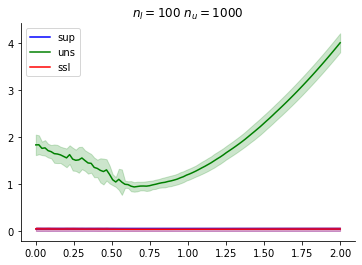

In [18]:
plot_vary_s_fixed_dataset_size(n_l=100, n_u=1000, uns_estimator_type='EM', num_weight_est_seed=10, num_seed=10)

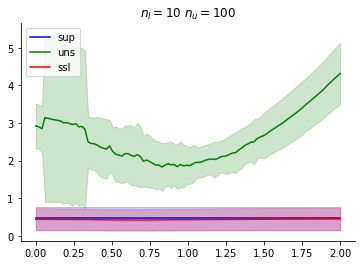

In [19]:
plot_vary_s_fixed_dataset_size(n_l=10, n_u=100, uns_estimator_type='EM', num_weight_est_seed=50, num_seed=50)

In [20]:
# Self Training Class

# EM with initialization using supervised samples

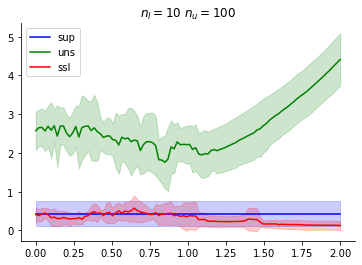

In [21]:
plot_vary_s_fixed_dataset_size(n_l=10, n_u=100, uns_estimator_type='EM', ssl_estimator_type='EM_init' ,num_weight_est_seed=1, num_seed=10)

# Self Training

In [19]:
import numpy as np
from sklearn import datasets
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression

def expectation_maximization_supervised_init(x_unlabeled=x_unlabeled,x_1_labeled= x_1_labeled, x_2_labeled= x_2_labeled ):
    mean_1 = np.mean(x_1_labeled, axis=0)
    mean_2 = np.mean(x_2_labeled, axis=0)
    means_init = np.append(mean_1[None, :], mean_2[None, :] ,axis=0)
    gm = GaussianMixture(n_components=2, random_state=0, means_init = means_init ).fit(x_unlabeled)
    return gm.means_

def expectation_maximization_kmeans_init(x_unlabeled):
    gm = GaussianMixture(n_components=2, random_state=0, covariance_type='spherical').fit(x_unlabeled)
    return gm.means_

def get_unsup_estimator(x_unlabelled, x_test, y_test):
#     print(x_unlabelled.shape)
    em_means = expectation_maximization_kmeans_init(x_unlabelled)
#     print(em_means)
    clf_em = LogisticRegression(random_state=0)
#     print(em_means.shape)
    clf_em.coef_=(em_means[0]-em_means[1]).reshape(1,-1)
    clf_em.intercept_=0
    clf_em.classes_=np.unique(y_test)
#     print(vars(clf_em), x_test.shape, y_test.shape)
    if clf_em.score(x_test, y_test) <0.5:
        clf_em.coef_*=-1
    return clf_em

def get_sup_estimator(x_labelled, y):
    clf = LogisticRegression(random_state=0).fit(x_labelled, y)
    return clf


import itertools


def self_training(x_unlabeled, x_labeled, y_labeled, x_val, y_val):

    rng = np.random.RandomState(42)
    
    X_labelled_all=np.concatenate((x_labeled, x_unlabeled))
    Y_labelled_all=np.concatenate((y_labeled, [-1]*len(x_unlabeled)))
    
    best_clf=None
    best_acc=0.
    
    for criterion in ['threshold', 'k_best']:
        for C in [1]:#[0.1, 1, 10, 100]:
            if criterion == 'thrshold':
                for threshold in [0.8]:#np.linspace(0.3,1,10):
                    svc = LogisticRegression(C=C)
                    self_training_model = SelfTrainingClassifier(svc, criterion='threshold', threshold=threshold)
                    self_training_model.fit(X_labelled_all, Y_labelled_all)
                    if self_training_model.score(x_val, y_val) > best_acc:
                        best_clf=self_tr
            if criterion == 'k_best':
                for k_best in [10]:#np.arange(5,20):
                    svc = LogisticRegression(C=C)
                    self_training_model = SelfTrainingClassifier(svc,criterion='k_best', k_best=k_best)
                    self_training_model.fit(X_labelled_all, Y_labelled_all)
                    if self_training_model.score(x_val, y_val) > best_acc:
                        best_clf=self_training_model
    return best_clf

from sklearn.semi_supervised import LabelPropagation

def get_lbl_prop_est(x_unlabeled, x_labeled, y_labeled):
    label_prop_model = LabelPropagation(n_jobs=-1)
    X_labelled_all=np.concatenate((x_labeled, x_unlabeled))
    Y_labelled_all=np.concatenate((y_labeled, [-1]*len(x_unlabeled)))
    
    label_prop_model.fit(X_labelled_all, Y_labelled_all)
    return label_prop_model



from tqdm import tqdm
def get_best_lambda(clf_sl, clf_em, x_test, y_test):    
    score_arr=[]
    best_lambda=0
    best_score=0
    for lambda_ in np.linspace(0,1,1000):
        clf_ssl=get_ssl_estimator(clf_sl, clf_em, lambda_)
        score_curr = clf_ssl.score(x_test, y_test)
        if score_curr > best_score:
            best_lambda=lambda_
            best_score = score_curr
    return best_lambda, best_score


def get_ssl_estimator(clf_sl, clf_em, lambda_):
    clf_ssl = LogisticRegression(random_state=0)
    w=lambda_*clf_em.coef_ + (1-lambda_)*clf_sl.coef_
    w0=(1-lambda_)*clf_sl.intercept_

    clf_ssl.coef_=w
    clf_ssl.intercept_=w0
    clf_ssl.classes_=clf_sl.classes_
    return clf_ssl

    

In [20]:

def plot_vary_s_fixed_dataset_size(n_l, n_u):
    D = 2
    THETA = np.ones(D)/np.sqrt(D)
    s_values = np.linspace(0.01,1,50)
    ssl_arr=[]
    theory_arr=[]
    lambda_arr=[]

    sl_arr=[]
    ul_arr=[]
    st_arr=[]
    lp_arr=[]

    n_labelled_arrs=[]
    n_unlabelled_arrs=[]
    snr_arr = []
    for ind, s in enumerate(s_values):
        err_s = []
        err_u = []
        err_ssl = []
        for seed in range(1,10):
            x_1_labeled, x_2_labeled, x_unlabelled = create_dataset_symmetric_mixture(theta=s*THETA, 
                                                                                      d=D,
                                                                                     n_1_unl=int(n_u/2), 
                                                                                     n_2_unl=int(n_u/2), 
                                                                                     n_1_labeled=int(n_l/2)+2000, 
                                                                                     n_2_labeled=int(n_l/2)+2000, 
                                                                                     seed= seed)

            x_labeled=np.concatenate((x_1_labeled[:-2000], x_2_labeled[:-2000]))
            y_labeled = np.asarray([1]*len(x_1_labeled[:-2000])+[2]*len(x_2_labeled[:-2000]))
            perm_idx=np.random.permutation(len(x_labeled))
            x_labeled=x_labeled[perm_idx]
            y_labeled=y_labeled[perm_idx]
            
            
            x_val=np.concatenate((x_1_labeled[-2000:-1000], x_2_labeled[-2000:-1000]))
            y_val = np.concatenate(([1]*1000,[2]*1000))
            
            x_test=np.concatenate((x_1_labeled[-1000:], x_2_labeled[-1000:]))
            y_test = np.concatenate(([1]*1000,[2]*1000))
            

            clf_em=get_unsup_estimator(x_unlabelled, x_val, y_val)
            clf_sl=get_sup_estimator(x_labeled,y_labeled)
            clf_st=self_training(x_unlabelled, x_labeled, y_labeled, x_val, y_val)
#             clf_lbl_prop=get_lbl_prop_est(x_unlabelled, x_labeled, y_labeled)
            
            sl_score=clf_sl.score(x_test, y_test)
            ul_score=clf_em.score(x_test, y_test)
            st_score=clf_st.score(x_test, y_test)
#             lp_score=clf_lbl_prop.score(x_test, y_test)
            
            best_lambda,_ = get_best_lambda(clf_sl, clf_em, x_val, y_val)
            clf_ssl=get_ssl_estimator(clf_sl, clf_em, best_lambda)
            ssl_score=clf_ssl.score(x_test, y_test)
            
            ssl_arr.append(1.-ssl_score)
            lambda_arr.append(1.-best_lambda)
            sl_arr.append(1.-sl_score)
            ul_arr.append(1.-ul_score)
            st_arr.append(1.-st_score)
#             lp_arr.append(1.-lp_score)
            snr_arr.append(s)
    return sl_arr, ssl_arr, ul_arr, st_arr, lp_arr, snr_arr


In [21]:
sl_arr, ssl_arr, ul_arr, st_arr, lp_arr, snr_arr=plot_vary_s_fixed_dataset_size(n_l=50, n_u=1000)

[0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]


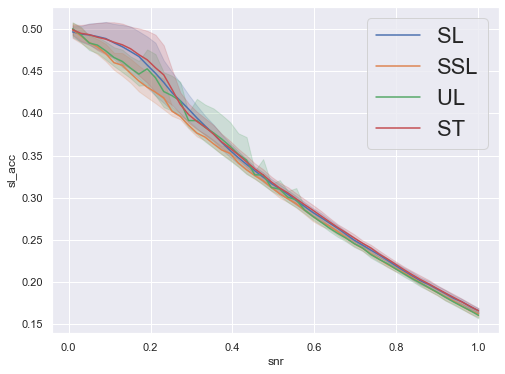

In [22]:
print(THETA)
import pandas as pd
import seaborn as sns
# print(df)
val_dict={'snr':snr_arr,
         'sl_acc':sl_arr,
         'ssl_acc':ssl_arr,
         'ul_acc':ul_arr,
         'st_acc':st_arr,
#          'lp_acc':lp_arr,
         }
df=pd.DataFrame.from_dict(val_dict)
import seaborn as sns
sns.set()
fig,ax=plt.subplots(figsize=(8,6))
sns.lineplot(data=df, x='snr', y='sl_acc',ax=ax, label='SL ')
sns.lineplot(data=df, x='snr', y='ssl_acc',ax=ax, label='SSL')
sns.lineplot(data=df, x='snr', y='ul_acc',ax=ax, label='UL ')
sns.lineplot(data=df, x='snr', y='st_acc',ax=ax, label='ST ')
# sns.lineplot(data=df, x='snr', y='lp_acc',ax=ax, label='LP ')
# ax.set_xscale('log')
# ax.set_yscale('log')
# sns.lineplot(data=df, x='n_labelled', y='sl_acc',ax=ax, label='SSL-SL')
ax.legend(fontsize=22)

In [118]:
def get_unsup_estimator_for_estimation(x_unlabelled):
#     print(x_unlabelled.shape)
    em_means = expectation_maximization_kmeans_init(x_unlabelled)
#     print(em_means)
    return 0.5*(em_means[0]-em_means[1].reshape(1,-1))

def get_sup_estimator_for_estimation(x_labelled, y):
    return np.dot(x_labelled.transpose(), y)/len(y)

from tqdm import tqdm
def get_best_lambda_for_estimation(est_s, est_u, theta_star):    
    score_arr=[]
    best_lambda=0
    best_score=10^6
    for lambda_ in np.linspace(0,1,1000):
#         print(theta_star)
        if np.linalg.norm(theta_star - est_u)> np.linalg.norm(-theta_star - est_u):
            est_u_signed = est_u*-1.
        else:
            est_u_signed=est_u
        est_ssl=lambda_*est_s + (1-lambda_)*est_u_signed 
        score_curr=np.linalg.norm(theta_star - est_ssl)**2
        if score_curr < best_score:
            best_lambda=lambda_
            best_score = score_curr
    return best_lambda, best_score

def plot_vary_s_fixed_dataset_size_est_error(n_l, n_u, lambda_cross_validate=True):
    D = 2
    THETA = np.ones(D)/np.sqrt(D)
    s_values = np.linspace(0.001,1,50)
    ssl_arr=[]
    theory_arr=[]
    lambda_arr=[]

    sl_arr=[]
    ul_arr=[]
    st_arr=[]
    lp_arr=[]
    switch_arr=[]

    n_labelled_arrs=[]
    n_unlabelled_arrs=[]
    snr_arr = []
    for ind, s in enumerate(s_values):
        err_s = []
        err_u = []
        err_ssl = []
        for seed in range(1,100):
            x_1_labeled, x_2_labeled, x_unlabelled = create_dataset_symmetric_mixture(theta=s*THETA, 
                                                                                      d=D,
                                                                                     n_1_unl=int(n_u/2), 
                                                                                     n_2_unl=int(n_u/2), 
                                                                                     n_1_labeled=int(n_l/2)+2000, 
                                                                                     n_2_labeled=int(n_l/2)+2000, 
                                                                                     seed= seed)

            x_labeled=np.concatenate((x_1_labeled[:-2000], x_2_labeled[:-2000]))
            y_labeled = np.asarray([1]*len(x_1_labeled[:-2000])+[-1]*len(x_2_labeled[:-2000]))
            perm_idx=np.random.permutation(len(x_labeled))
            x_labeled=x_labeled[perm_idx]
            y_labeled=y_labeled[perm_idx]
            
            
            x_val=np.concatenate((x_1_labeled[-2000:-1000], x_2_labeled[-2000:-1000]))
            y_val = np.concatenate(([1]*1000,[2]*1000))
            
            x_test=np.concatenate((x_1_labeled[-1000:], x_2_labeled[-1000:]))
            y_test = np.concatenate(([1]*1000,[2]*1000))
            

            est_u=get_unsup_estimator_for_estimation(x_unlabelled)
            est_s=get_sup_estimator_for_estimation(x_labeled,y_labeled)
            
            sl_score=np.linalg.norm(s*THETA - est_s)**2
            ul_score=min([np.linalg.norm(s*THETA - est_u), np.linalg.norm(-s*THETA - est_u)])**2
            
            if lambda_cross_validate:
                best_lambda,ssl_score = get_best_lambda_for_estimation(est_s, est_u, s*THETA)
            else:
                best_lambda=ul_score/(sl_score+ ul_score)
                est_ssl_1=best_lambda*est_s + (1.-best_lambda)*est_u
                est_ssl_2=best_lambda*est_s - (1.-best_lambda)*est_u
                ssl_score=min(np.linalg.norm(s*THETA - est_ssl_1)**2, np.linalg.norm(s*THETA - est_ssl_2)**2)
                
#             clf_ssl=get_ssl_estimator(clf_sl, clf_em, best_lambda)
#             ssl_score=clf_ssl.score(x_test, y_test)
            
            ssl_arr.append(ssl_score)
            lambda_arr.append(best_lambda)
            sl_arr.append(sl_score)
            ul_arr.append(ul_score)
            switch_arr.append(min(ul_score, sl_score))
#             st_arr.append(st_score)
#             lp_arr.append(1.-lp_score)
            snr_arr.append(s)
    return np.asarray(sl_arr), np.asarray(ssl_arr), np.asarray(switch_arr), np.asarray(ul_arr), np.asarray(snr_arr)

def plot_vary_nlab_fixed_else_est_error(s, n_u, lambda_cross_validate=True):
    D = 2
    THETA = np.ones(D)/np.sqrt(D)
    n_l_arr = np.linspace(10,300, 290)
    ssl_arr=[]
    theory_arr=[]
    lambda_arr=[]

    sl_arr=[]
    ul_arr=[]
    st_arr=[]
    lp_arr=[]
    switch_arr=[]

    n_labelled_arrs=[]
    n_unlabelled_arrs=[]
    snr_arr = []
    for ind, n_l in enumerate(n_l_arr):
        err_s = []
        err_u = []
        err_ssl = []
        for seed in range(1,100):
            n_labelled_arrs.append(n_l)
            x_1_labeled, x_2_labeled, x_unlabelled = create_dataset_symmetric_mixture(theta=s*THETA, 
                                                                                      d=D,
                                                                                     n_1_unl=int(n_u/2), 
                                                                                     n_2_unl=int(n_u/2), 
                                                                                     n_1_labeled=int(n_l/2)+2000, 
                                                                                     n_2_labeled=int(n_l/2)+2000, 
                                                                                     seed= seed)

            x_labeled=np.concatenate((x_1_labeled[:-2000], x_2_labeled[:-2000]))
            y_labeled = np.asarray([1]*len(x_1_labeled[:-2000])+[-1]*len(x_2_labeled[:-2000]))
            perm_idx=np.random.permutation(len(x_labeled))
            x_labeled=x_labeled[perm_idx]
            y_labeled=y_labeled[perm_idx]
            
            
            x_val=np.concatenate((x_1_labeled[-2000:-1000], x_2_labeled[-2000:-1000]))
            y_val = np.concatenate(([1]*1000,[2]*1000))
            
            x_test=np.concatenate((x_1_labeled[-1000:], x_2_labeled[-1000:]))
            y_test = np.concatenate(([1]*1000,[2]*1000))
            

            est_u=get_unsup_estimator_for_estimation(x_unlabelled)
            est_s=get_sup_estimator_for_estimation(x_labeled,y_labeled)
            
            sl_score=np.linalg.norm(s*THETA - est_s)**2
            ul_score=min([np.linalg.norm(s*THETA - est_u), np.linalg.norm(-s*THETA - est_u)])**2
            
            if lambda_cross_validate:
                best_lambda,ssl_score = get_best_lambda_for_estimation(est_s, est_u, s*THETA)
            else:
                best_lambda=ul_score/(sl_score+ ul_score)
                est_ssl_1=best_lambda*est_s + (1.-best_lambda)*est_u
                est_ssl_2=best_lambda*est_s - (1.-best_lambda)*est_u
                ssl_score=min(np.linalg.norm(s*THETA - est_ssl_1)**2, np.linalg.norm(s*THETA - est_ssl_2)**2)
                
#             clf_ssl=get_ssl_estimator(clf_sl, clf_em, best_lambda)
#             ssl_score=clf_ssl.score(x_test, y_test)
            
            ssl_arr.append(ssl_score)
            lambda_arr.append(best_lambda)
            sl_arr.append(sl_score)
            ul_arr.append(ul_score)
            switch_arr.append(min(ul_score, sl_score))
#             st_arr.append(st_score)
#             lp_arr.append(1.-lp_score)
            snr_arr.append(s)
    return np.asarray(sl_arr), np.asarray(ssl_arr), np.asarray(switch_arr), np.asarray(ul_arr), np.asarray(n_labelled_arrs)


def plot_vary_nunl_fixed_else_est_error(s, n_l, lambda_cross_validate=True):
    D = 2
    THETA = np.ones(D)/np.sqrt(D)
    n_l_arr = np.linspace(10,300, 290)
    ssl_arr=[]
    theory_arr=[]
    lambda_arr=[]

    sl_arr=[]
    ul_arr=[]
    st_arr=[]
    lp_arr=[]
    switch_arr=[]

    n_labelled_arrs=[]
    n_unlabelled_arrs=[]
    snr_arr = []
    for ind, n_l in enumerate(n_l_arr):
        err_s = []
        err_u = []
        err_ssl = []
#         for seed in range(1,100):
        for seed in range(1,20):
            n_labelled_arrs.append(n_l)
            x_1_labeled, x_2_labeled, x_unlabelled = create_dataset_symmetric_mixture(theta=s*THETA, 
                                                                                      d=D,
                                                                                     n_1_unl=int(n_u/2), 
                                                                                     n_2_unl=int(n_u/2), 
                                                                                     n_1_labeled=int(n_l/2)+2000, 
                                                                                     n_2_labeled=int(n_l/2)+2000, 
                                                                                     seed= seed)

            x_labeled=np.concatenate((x_1_labeled[:-2000], x_2_labeled[:-2000]))
            y_labeled = np.asarray([1]*len(x_1_labeled[:-2000])+[-1]*len(x_2_labeled[:-2000]))
            perm_idx=np.random.permutation(len(x_labeled))
            x_labeled=x_labeled[perm_idx]
            y_labeled=y_labeled[perm_idx]
            
            
            x_val=np.concatenate((x_1_labeled[-2000:-1000], x_2_labeled[-2000:-1000]))
            y_val = np.concatenate(([1]*1000,[2]*1000))
            
            x_test=np.concatenate((x_1_labeled[-1000:], x_2_labeled[-1000:]))
            y_test = np.concatenate(([1]*1000,[2]*1000))
            

            est_u=get_unsup_estimator_for_estimation(x_unlabelled)
            est_s=get_sup_estimator_for_estimation(x_labeled,y_labeled)
            
            sl_score=np.linalg.norm(s*THETA - est_s)**2
            ul_score=min([np.linalg.norm(s*THETA - est_u), np.linalg.norm(-s*THETA - est_u)])**2
            
            if lambda_cross_validate:
                best_lambda,ssl_score = get_best_lambda_for_estimation(est_s, est_u, s*THETA)
            else:
                best_lambda=ul_score/(sl_score+ ul_score)
                est_ssl_1=best_lambda*est_s + (1.-best_lambda)*est_u
                est_ssl_2=best_lambda*est_s - (1.-best_lambda)*est_u
                ssl_score=min(np.linalg.norm(s*THETA - est_ssl_1)**2, np.linalg.norm(s*THETA - est_ssl_2)**2)
                
#             clf_ssl=get_ssl_estimator(clf_sl, clf_em, best_lambda)
#             ssl_score=clf_ssl.score(x_test, y_test)
            
            ssl_arr.append(ssl_score)
            lambda_arr.append(best_lambda)
            sl_arr.append(sl_score)
            ul_arr.append(ul_score)
            switch_arr.append(min(ul_score, sl_score))
#             st_arr.append(st_score)
#             lp_arr.append(1.-lp_score)
            snr_arr.append(s)
    return np.asarray(sl_arr), np.asarray(ssl_arr), np.asarray(switch_arr), np.asarray(ul_arr), np.asarray(n_labelled_arrs)

In [49]:
sl_arr_est1, ssl_arr_est1, switch_arr_est1, ul_arr_est1,  snr_arr_est1=plot_vary_s_fixed_dataset_size_est_error(n_l=100, n_u=5000, lambda_cross_validate=False)



[0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]


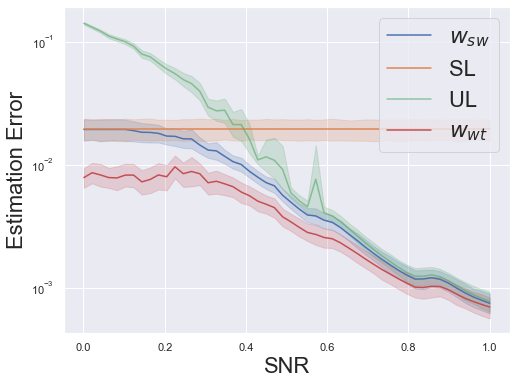

In [50]:
print(THETA)
import pandas as pd
import seaborn as sns
# print(df)
val_dict={'snr':snr_arr_est1,
         'sl_err':sl_arr_est1,
         'ssl_err':ssl_arr_est1,
         'ul_err':ul_arr_est1,
         'switch_err':switch_arr_est1,
#          'lp_acc':lp_arr,
         }
df=pd.DataFrame.from_dict(val_dict)
import seaborn as sns
sns.set()
fig,ax=plt.subplots(figsize=(8,6))
sns.lineplot(data=df, x='snr', y='switch_err',ax=ax, label='$w_{sw}$ ', alpha=1.)

sns.lineplot(data=df, x='snr', y='sl_err',ax=ax, label='SL ', alpha=1.)
sns.lineplot(data=df, x='snr', y='ul_err',ax=ax, label='UL ', alpha=0.6)
sns.lineplot(data=df, x='snr', y='ssl_err',ax=ax, label='$w_{wt}$')
# sns.lineplot(data=df, x='snr', y='lp_acc',ax=ax, label='LP ')
# ax.set_xscale('log')
ax.set_yscale('log')
# sns.lineplot(data=df, x='n_labelled', y='sl_acc',ax=ax, label='SSL-SL')
ax.set_ylabel('Estimation Error', fontsize=22)
ax.set_xlabel('SNR', fontsize=22)
ax.legend(fontsize=22, loc='upper right')
fig.savefig('comp_switch_weight.pdf')

In [58]:
llll=np.arange(10)
llll[::2]

array([0, 2, 4, 6, 8])

In [70]:
sl_arr_est1.reshape((50, -1))[::10].shape

(5, 99)

[0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]


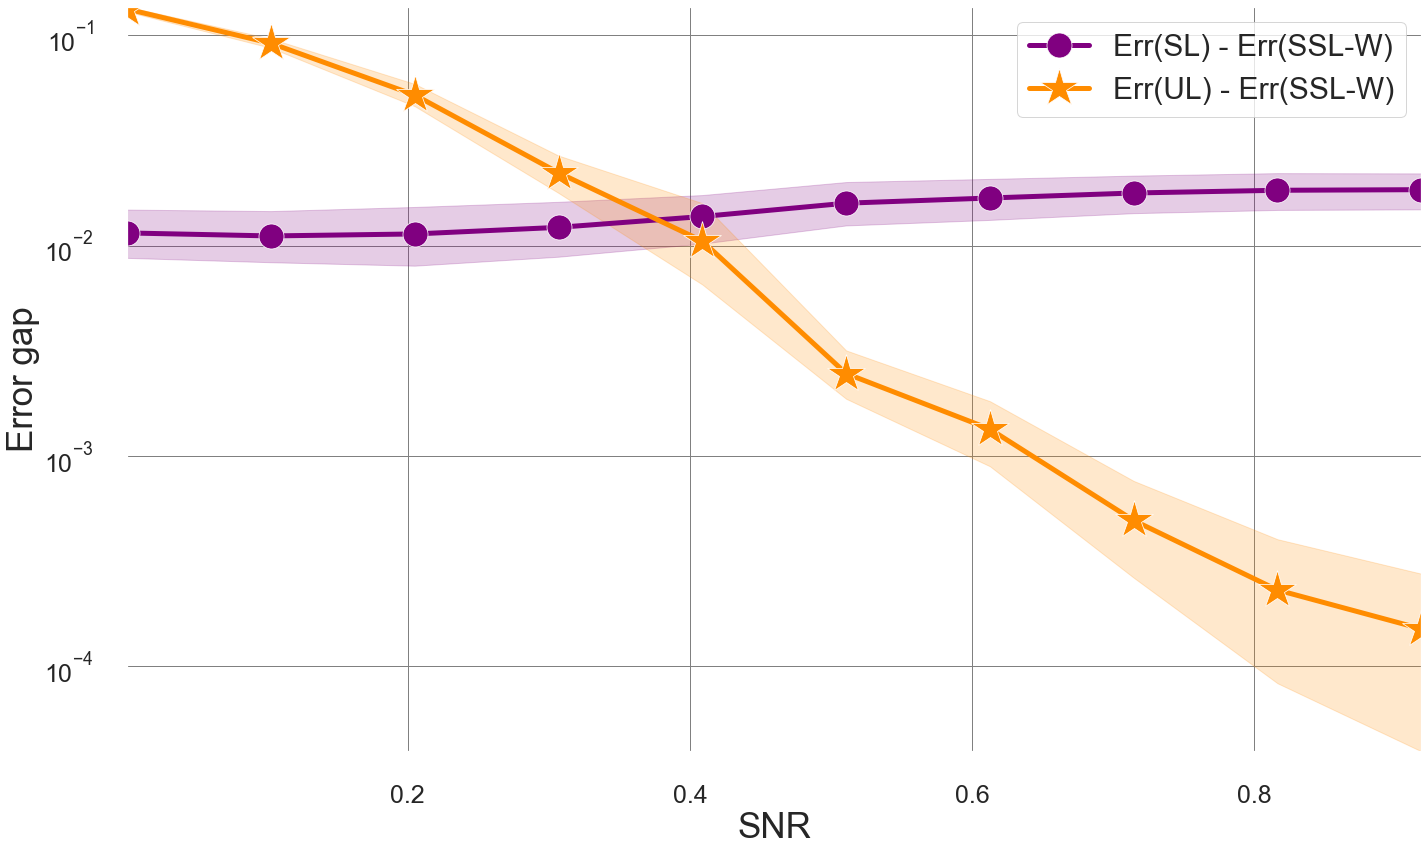

In [137]:
print(THETA)
import pandas as pd
import seaborn as sns
# print(df)

subsample_freq = 5
x_og_size = np.unique(snr_arr_est1).shape[0]

val_dict={'snr':snr_arr_est1.reshape((x_og_size, -1))[::subsample_freq].reshape(-1),
         'sl_err_diff':(sl_arr_est1-ssl_arr_est1).reshape((x_og_size, -1))[::subsample_freq].reshape(-1),
         'ul_err_diff':(ul_arr_est1-ssl_arr_est1).reshape((x_og_size, -1))[::subsample_freq].reshape(-1),
#          'lp_acc':lp_arr,
         }
df=pd.DataFrame.from_dict(val_dict)
import seaborn as sns
sns.set()
# fig,ax=plt.subplots(figsize=(12,9))
fig,ax=plt.subplots(figsize=(20,12))
# sns.lineplot(data=df, x='snr', y='switch_err',ax=ax, label='$w_{sw}$ ', alpha=1.)

sns.lineplot(data=df, x='snr', y='sl_err_diff',ax=ax, label='Err(SL) - Err(SSL-W)', linewidth=5,
             marker="o", markersize=25, color="purple")
sns.lineplot(data=df, x='snr', y='ul_err_diff',ax=ax, label='Err(UL) - Err(SSL-W)', linewidth=5,
             marker="*", markersize=40, color="darkorange")
# sns.lineplot(data=df, x='snr', y='ssl_err',ax=ax, label='$w_{wt}$')
# sns.lineplot(data=df, x='snr', y='lp_acc',ax=ax, label='LP ')
# ax.set_xscale('log')
ax.set_yscale('log')
# sns.lineplot(data=df, x='n_labelled', y='sl_acc',ax=ax, label='SSL-SL')
# ax.set_ylabel('Error gap', fontsize=22)
# ax.set_xlabel('SNR', fontsize=22)
# ax.legend(fontsize=22, loc='upper right')

# sns.set(font_scale=3)
# ax.set_title(f"Err[SSL-S] - Err[SSL-W], $n_u=10000$")
ax.set_xlabel("SNR", fontsize=35)
ax.set_ylabel("Error gap", fontsize=35)
ax.tick_params(axis="x", labelsize=25, size=30)
ax.tick_params(axis="y", labelsize=25, size=30)
ax.legend(fontsize=30, facecolor="white")
plt.margins(0)
plt.tight_layout()

ax.set_facecolor('white')
ax.set_axisbelow(True)
plt.grid(color='gray', linestyle='solid')

filename = 'comp_switch_weight_snr.pdf'
plt.savefig(f'/Users/alexandrutifrea/Projects/SSL_lower_bound/SSL_compatibility_lb/neurips2023/figures/{filename}')


[0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]


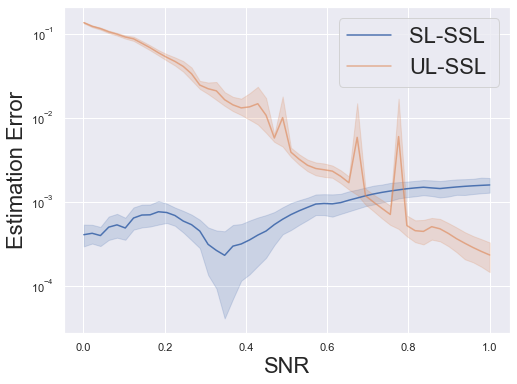

In [47]:
print(THETA)
import pandas as pd
import seaborn as sns
# print(df)
val_dict={'snr':snr_arr_est_1000,
         'sl_err_diff':sl_arr_est_1000-ssl_arr_est_1000,
         'ul_err_diff':ul_arr_est_1000-ssl_arr_est_1000,
#          'lp_acc':lp_arr,
         }
df=pd.DataFrame.from_dict(val_dict)
import seaborn as sns
sns.set()
fig,ax=plt.subplots(figsize=(8,6))
# sns.lineplot(data=df, x='snr', y='switch_err',ax=ax, label='$w_{sw}$ ', alpha=1.)

sns.lineplot(data=df, x='snr', y='sl_err_diff',ax=ax, label='SL-SSL ', alpha=1.)
sns.lineplot(data=df, x='snr', y='ul_err_diff',ax=ax, label='UL-SSL', alpha=0.6)
# sns.lineplot(data=df, x='snr', y='ssl_err',ax=ax, label='$w_{wt}$')
# sns.lineplot(data=df, x='snr', y='lp_acc',ax=ax, label='LP ')
# ax.set_xscale('log')
ax.set_yscale('log')
# sns.lineplot(data=df, x='n_labelled', y='sl_acc',ax=ax, label='SSL-SL')
ax.set_ylabel('Estimation Error', fontsize=22)
ax.set_xlabel('SNR', fontsize=22)
ax.legend(fontsize=22, loc='upper right')

In [43]:
sl_arr_est_10, ssl_arr_est_10, switch_arr_est_10, ul_arr_est_10,  snr_arr_est_10=plot_vary_s_fixed_dataset_size_est_error(n_l=10, n_u=10000, lambda_cross_validate=False)

sl_arr_est_100, ssl_arr_est_100, switch_arr_est_100, ul_arr_est_100,  snr_arr_est_100=plot_vary_s_fixed_dataset_size_est_error(n_l=100, n_u=10000, lambda_cross_validate=False)

sl_arr_est_1000, ssl_arr_est_1000, switch_arr_est_1000, ul_arr_est_1000,  snr_arr_est_1000=plot_vary_s_fixed_dataset_size_est_error(n_l=1000, n_u=10000, lambda_cross_validate=False)



In [48]:
sl_arr_est_500, ssl_arr_est_500, switch_arr_est_500, ul_arr_est_500,  snr_arr_est_500=plot_vary_s_fixed_dataset_size_est_error(n_l=500, n_u=10000, lambda_cross_validate=False)


[0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]


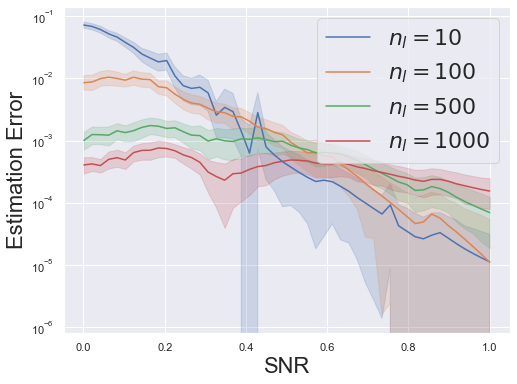

In [51]:
print(THETA)
import pandas as pd
import seaborn as sns
# print(df)
val_dict={'snr10':snr_arr_est_10,
          'snr100':snr_arr_est_100,
          'snr500':snr_arr_est_500,
          'snr1000':snr_arr_est_1000,
         'sw_err_diff_10':switch_arr_est_10-ssl_arr_est_10,
         'sw_err_diff_100':switch_arr_est_100-ssl_arr_est_100,
         'sw_err_diff_500':switch_arr_est_500-ssl_arr_est_500,
         'sw_err_diff_1000':switch_arr_est_1000-ssl_arr_est_1000,
#          'lp_acc':lp_arr,
         }
df=pd.DataFrame.from_dict(val_dict)
import seaborn as sns
sns.set()
fig,ax=plt.subplots(figsize=(8,6))
# sns.lineplot(data=df, x='snr', y='switch_err',ax=ax, label='$w_{sw}$ ', alpha=1.)

sns.lineplot(data=df, x='snr10', y='sw_err_diff_10',ax=ax, label='$n_l=10$', alpha=1.)
sns.lineplot(data=df, x='snr100', y='sw_err_diff_100',ax=ax, label='$n_l=100$', alpha=1)
sns.lineplot(data=df, x='snr500', y='sw_err_diff_500',ax=ax, label='$n_l=500$', alpha=1)
sns.lineplot(data=df, x='snr1000', y='sw_err_diff_1000',ax=ax, label='$n_l=1000$', alpha=1)
# sns.lineplot(data=df, x='snr', y='ssl_err',ax=ax, label='$w_{wt}$')
# sns.lineplot(data=df, x='snr', y='lp_acc',ax=ax, label='LP ')
# ax.set_xscale('log')
ax.set_yscale('log')
# sns.lineplot(data=df, x='n_labelled', y='sl_acc',ax=ax, label='SSL-SL')
ax.set_ylabel('Estimation Error', fontsize=22)
ax.set_xlabel('SNR', fontsize=22)
ax.legend(fontsize=22, loc='upper right')
# fig.savefig('comp_switch_weight_snr.pdf')

In [130]:
# sl_arr_est, ssl_arr_est, switch_arr_est, ul_arr_est,  n_labelled_est=plot_vary_nlab_fixed_else_est_error(s=0.5, n_u=5000, lambda_cross_validate=False)
sl_arr_est, ssl_arr_est, switch_arr_est, ul_arr_est,  n_labelled_est=plot_vary_nlab_fixed_else_est_error(s=0.1, n_u=5000, lambda_cross_validate=False)



[0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]


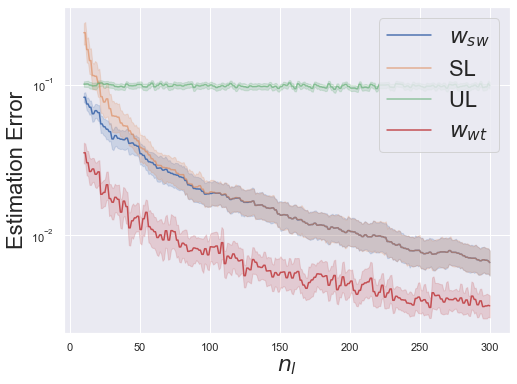

In [132]:
print(THETA)
import pandas as pd
import seaborn as sns
# print(df)
val_dict={'n_lab':n_labelled_est,
         'sl_err':sl_arr_est,
         'ssl_err':ssl_arr_est,
         'ul_err':ul_arr_est,
         'switch_err':switch_arr_est,
#          'lp_acc':lp_arr,
         }
df=pd.DataFrame.from_dict(val_dict)
import seaborn as sns
sns.set()
fig,ax=plt.subplots(figsize=(8,6))
sns.lineplot(data=df, x='n_lab', y='switch_err',ax=ax, label='$w_{sw}$ ', alpha=1.)

sns.lineplot(data=df, x='n_lab', y='sl_err',ax=ax, label='SL ', alpha=0.6)
sns.lineplot(data=df, x='n_lab', y='ul_err',ax=ax, label='UL ', alpha=0.6)
sns.lineplot(data=df, x='n_lab', y='ssl_err',ax=ax, label='$w_{wt}$')
# sns.lineplot(data=df, x='snr', y='lp_acc',ax=ax, label='LP ')
# ax.set_xscale('log')
ax.set_yscale('log')
# sns.lineplot(data=df, x='n_labelled', y='sl_acc',ax=ax, label='SSL-SL')
ax.set_ylabel('Estimation Error', fontsize=22)
ax.set_xlabel('$n_l$', fontsize=22)
ax.legend(fontsize=22, loc='upper right')
fig.savefig('comp_switch_weight.pdf')

[0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]


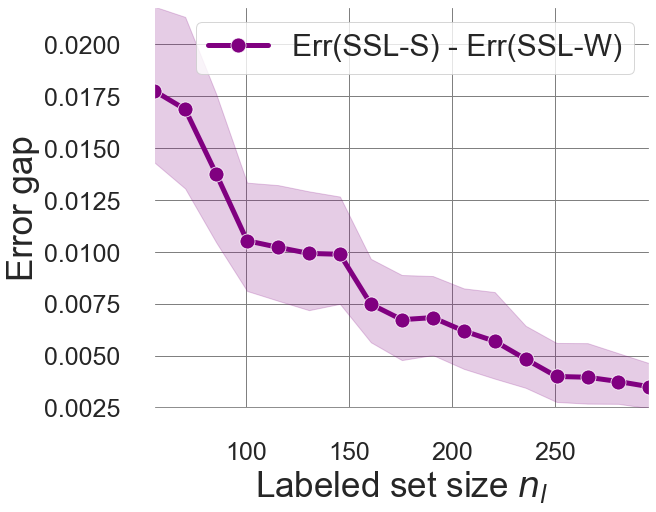

In [136]:
print(THETA)
import pandas as pd
import seaborn as sns
# print(df)

subsample_freq = 15
snr_og_size = np.unique(n_labelled_est).shape[0]

val_dict={'n_lab':n_labelled_est.reshape((snr_og_size, -1))[::subsample_freq][3:].reshape(-1),
         'sl_err_diff':(sl_arr_est-ssl_arr_est).reshape((snr_og_size, -1))[::subsample_freq][3:].reshape(-1),
         'ul_err_diff':(ul_arr_est-ssl_arr_est).reshape((snr_og_size, -1))[::subsample_freq][3:].reshape(-1),
         'switch_err_diff':(switch_arr_est-ssl_arr_est).reshape((snr_og_size, -1))[::subsample_freq][3:].reshape(-1),
#          'lp_acc':lp_arr,
         }
df=pd.DataFrame.from_dict(val_dict)
import seaborn as sns
sns.set()
# fig,ax=plt.subplots(figsize=(12,9))
fig,ax=plt.subplots(figsize=(10,8))
# fig,ax=plt.subplots(figsize=(8,6))
# sns.lineplot(data=df, x='n_lab', y='switch_err',ax=ax, label='$w_{sw}$ ', alpha=1.)

# sns.lineplot(data=df, x='n_lab', y='sl_err_diff',ax=ax, label='Err[SL] - Err[SSL-W]', 
#              marker="o", markersize=15, color="blue", linewidth=5)
# sns.lineplot(data=df, x='n_lab', y='ul_err_diff',ax=ax, label='Err[UL] - Err[SSL-W]', 
#              marker="*", markersize=25, color="red", linewidth=5)
sns.lineplot(data=df, x='n_lab', y='switch_err_diff',ax=ax, label='Err(SSL-S) - Err(SSL-W)',
             marker="o", markersize=15, color="purple", linewidth=5)
# sns.lineplot(data=df, x='n_lab', y='ssl_err',ax=ax, label='$w_{wt}$')
# sns.lineplot(data=df, x='snr', y='lp_acc',ax=ax, label='LP ')
# ax.set_xscale('log')
# ax.set_yscale('log')
# sns.lineplot(data=df, x='n_labelled', y='sl_acc',ax=ax, label='SSL-SL')
# ax.set_ylabel('Error gap', fontsize=22)
# ax.set_xlabel('$n_l$', fontsize=22)
# ax.legend(fontsize=22, loc='upper right')

sns.set(font_scale=3)
# ax.set_title("2-GMM with s=0.1")

ax.set_xlabel("Labeled set size $n_l$", fontsize=35)
ax.set_ylabel("Error gap", fontsize=35)
ax.tick_params(axis="x", labelsize=25, size=30)
ax.tick_params(axis="y", labelsize=25, size=30)
ax.legend(fontsize=30, facecolor="w")
plt.margins(0)
plt.tight_layout()

ax.set_facecolor('white')
ax.set_axisbelow(True)
plt.grid(color='gray', linestyle='solid')

filename = 'comp_switch_weight_nlab.pdf'
plt.savefig(f'/Users/alexandrutifrea/Projects/SSL_lower_bound/SSL_compatibility_lb/neurips2023/figures/{filename}')


In [22]:
np.linspace(0.001,1,50)

array([0.001     , 0.02138776, 0.04177551, 0.06216327, 0.08255102,
       0.10293878, 0.12332653, 0.14371429, 0.16410204, 0.1844898 ,
       0.20487755, 0.22526531, 0.24565306, 0.26604082, 0.28642857,
       0.30681633, 0.32720408, 0.34759184, 0.36797959, 0.38836735,
       0.4087551 , 0.42914286, 0.44953061, 0.46991837, 0.49030612,
       0.51069388, 0.53108163, 0.55146939, 0.57185714, 0.5922449 ,
       0.61263265, 0.63302041, 0.65340816, 0.67379592, 0.69418367,
       0.71457143, 0.73495918, 0.75534694, 0.77573469, 0.79612245,
       0.8165102 , 0.83689796, 0.85728571, 0.87767347, 0.89806122,
       0.91844898, 0.93883673, 0.95922449, 0.97961224, 1.        ])